In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import string
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

In [2]:
alito = pd.read_csv('alito.csv', encoding = "ISO-8859-1", engine='python')
breyer = pd.read_csv('breyer.csv', encoding = "ISO-8859-1", engine='python')
gorsuch = pd.read_csv('gorsuch.csv', encoding = "ISO-8859-1", engine='python')
kagan = pd.read_csv('kagan.csv', encoding = "ISO-8859-1", engine='python')
kavanaugh = pd.read_csv('kavanaugh.csv', encoding = "ISO-8859-1", engine='python')
roberts = pd.read_csv('roberts.csv', encoding = "ISO-8859-1", engine='python')
sotomayor = pd.read_csv('sotomayor.csv', encoding = "ISO-8859-1", engine='python')
thomas = pd.read_csv('thomas.csv', encoding = "ISO-8859-1", engine='python')

In [3]:
dataset = pd.concat([alito, breyer, gorsuch, kagan, kavanaugh, roberts, sotomayor, thomas])
dataset.columns= ['Sentence', 'Judge']
print(pd.unique(dataset['Judge']))
print("Shape of Dataset:", dataset.shape)
dataset.head()

['Alito' 'Breyer' 'Gorsuch' 'Kagan' 'Kavanaugh' 'Roberts' 'SOTOMAYOR'
 'Thomas']
Shape of Dataset: (11972, 2)


,Sentence,Judge
0,These cases concern the interplay between two...,Alito
1,Section 402(b) of the Clean Water Act require...,Alito
2,Section 7(a)(2) of the Endangered Species Act...,Alito
3,â The question presented is whether Â§7(a)(2...,Alito
4,We conclude that it does not,Alito


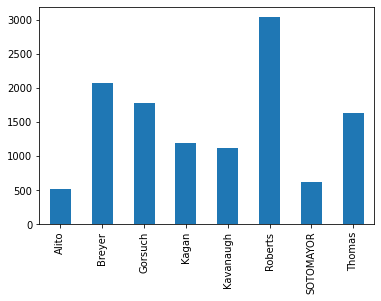

In [4]:
dataset['Judge'].value_counts().sort_index().plot.bar()

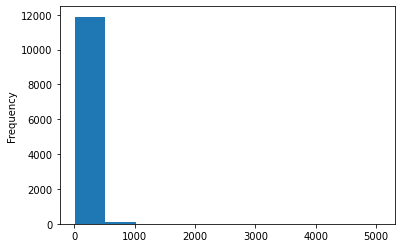

In [5]:
dataset['Sentence'].str.len().plot.hist()

In [6]:
dataset['Sentence'] = dataset['Sentence'].apply(lambda x: x.lower())
dataset.head()

,Sentence,Judge
0,these cases concern the interplay between two...,Alito
1,section 402(b) of the clean water act require...,Alito
2,section 7(a)(2) of the endangered species act...,Alito
3,â the question presented is whether â§7(a)(2...,Alito
4,we conclude that it does not,Alito


In [7]:

def clean_text(data):
  words = data.split()
  table = str.maketrans('', '', string.punctuation)
  words = [word.translate(table) for word in words]
  words = [word for word in words if word.isalpha() ]
  words = [word.lower() for word in words]
  return ' '.join(words)

dataset['Sentence'] = dataset['Sentence'].apply(clean_text)
dataset.head()

,Sentence,Judge
0,these cases concern the interplay between two ...,Alito
1,section of the clean water act requires that t...,Alito
2,section of the endangered species act of provi...,Alito
3,the question presented is whether effectively ...,Alito
4,we conclude that it does not,Alito


In [8]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(dataset['Sentence'].values)
X = tokenizer.texts_to_sequences(dataset['Sentence'].values)
X = sequence.pad_sequences(X)
pd.unique(dataset['Judge'])

array(['Alito', 'Breyer', 'Gorsuch', 'Kagan', 'Kavanaugh', 'Roberts',
       'SOTOMAYOR', 'Thomas'], dtype=object)

In [9]:
msaModel = tf.keras.models.Sequential()
msaModel.add(tf.keras.layers.Embedding(5000, 128, input_length= X.shape[1]))
msaModel.add(tf.keras.layers.Dropout(rate=0.2))
msaModel.add(tf.keras.layers.LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
msaModel.add(tf.keras.layers.LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
msaModel.add(tf.keras.layers.LSTM(units=128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
msaModel.add(tf.keras.layers.Dense(8, activation='softmax'))
msaModel.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
msaModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 676, 128)          640000    
_________________________________________________________________
dropout (Dropout)            (None, 676, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 676, 128)          131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 676, 128)          131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
Total params: 1,035,784
Trainable params: 1,035,784
Non-trainable params: 0
______________________________________________

In [10]:
y = pd.get_dummies(dataset['Judge']).values
[print(dataset['Judge'][i], y[i]) for i in range(5)]

0        Alito
0       Breyer
0      Gorsuch
0        Kagan
0    Kavanaugh
0      Roberts
0    SOTOMAYOR
0       Thomas
Name: Judge, dtype: object [1 0 0 0 0 0 0 0]
1        Alito
1       Breyer
1      Gorsuch
1        Kagan
1    Kavanaugh
1      Roberts
1    SOTOMAYOR
1       Thomas
Name: Judge, dtype: object [1 0 0 0 0 0 0 0]
2        Alito
2       Breyer
2      Gorsuch
2        Kagan
2    Kavanaugh
2      Roberts
2    SOTOMAYOR
2       Thomas
Name: Judge, dtype: object [1 0 0 0 0 0 0 0]
3        Alito
3       Breyer
3      Gorsuch
3        Kagan
3    Kavanaugh
3      Roberts
3    SOTOMAYOR
3       Thomas
Name: Judge, dtype: object [1 0 0 0 0 0 0 0]
4        Alito
4       Breyer
4      Gorsuch
4        Kagan
4    Kavanaugh
4      Roberts
4    SOTOMAYOR
4       Thomas
Name: Judge, dtype: object [1 0 0 0 0 0 0 0]


[None, None, None, None, None]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
msaModel.fit(X_train, y_train, epochs=15, batch_size=128, verbose=2)

Epoch 1/15
75/75 - 475s - loss: 1.8700 - accuracy: 0.2812
Epoch 2/15
75/75 - 474s - loss: 1.4817 - accuracy: 0.4174
Epoch 3/15
75/75 - 473s - loss: 1.0247 - accuracy: 0.6216
Epoch 4/15
75/75 - 473s - loss: 0.7157 - accuracy: 0.7522
Epoch 5/15
75/75 - 472s - loss: 0.5817 - accuracy: 0.7985
Epoch 6/15
75/75 - 473s - loss: 0.4799 - accuracy: 0.8344
Epoch 7/15
75/75 - 472s - loss: 0.4104 - accuracy: 0.8550
Epoch 8/15
75/75 - 471s - loss: 0.3794 - accuracy: 0.8662
Epoch 9/15
75/75 - 472s - loss: 0.3508 - accuracy: 0.8784
Epoch 10/15
75/75 - 472s - loss: 0.3241 - accuracy: 0.8869
Epoch 11/15
75/75 - 474s - loss: 0.2931 - accuracy: 0.8942
Epoch 12/15
75/75 - 475s - loss: 0.2887 - accuracy: 0.8987
Epoch 13/15
75/75 - 479s - loss: 0.2725 - accuracy: 0.9018
Epoch 14/15
75/75 - 481s - loss: 0.2620 - accuracy: 0.9049
Epoch 15/15
75/75 - 484s - loss: 0.2494 - accuracy: 0.9106


In [12]:
msaModel.save('ThreeJudgesSA.h5')

In [ ]:
results = []
counter = 0
resultsDF = pd.DataFrame(columns=['Inputs'])
while counter < 3:
  in_sentence = input("Enter Sentence: ")
  tempDF = pd.DataFrame({'Inputs':[in_sentence]})
  prediction = msaModel.predict(tempDF)
  if prediction not in results:
    counter += 1
    results.append(prediction)
    print(str(3-counter) + ' more inputs!')
  else:
    print('Try Again!')

In [ ]:
df = pd.DataFrame({'Predictions': results})
df.to_csv('ThreeJudgesSA.csv')